In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from lib_lorenz.datasets import mackey_glass
from lib_lorenz.observables import nrmse, rsquare
import lib_lorenz as rpy

In [22]:
timesteps = 2510
tau = 17
X = mackey_glass(timesteps, tau=tau)

# rescale between -1 and 1
X = 2 * (X - X.min()) / (X.max() - X.min()) - 1

In [5]:
def plot_mackey_glass(X, sample, tau):

    fig = plt.figure(figsize=(13, 5))
    N = sample

    ax = plt.subplot((121))
    t = np.linspace(0, N, N)
    for i in range(N-1):
        ax.plot(t[i:i+2], X[i:i+2], color=plt.cm.magma(255*i//N), lw=1.0)

    plt.title(f"Timeseries - {N} timesteps")
    plt.xlabel("$t$")
    plt.ylabel("$P(t)$")

    ax2 = plt.subplot((122))
    ax2.margins(0.05)
    for i in range(N-1):
        ax2.plot(X[i:i+2], X[i+tau:i+tau+2], color=plt.cm.magma(255*i//N), lw=1.0)

    plt.title(f"Phase diagram: $P(t) = f(P(t-\\tau))$")
    plt.xlabel("$P(t-\\tau)$")
    plt.ylabel("$P(t)$")

    plt.tight_layout()
    plt.show()

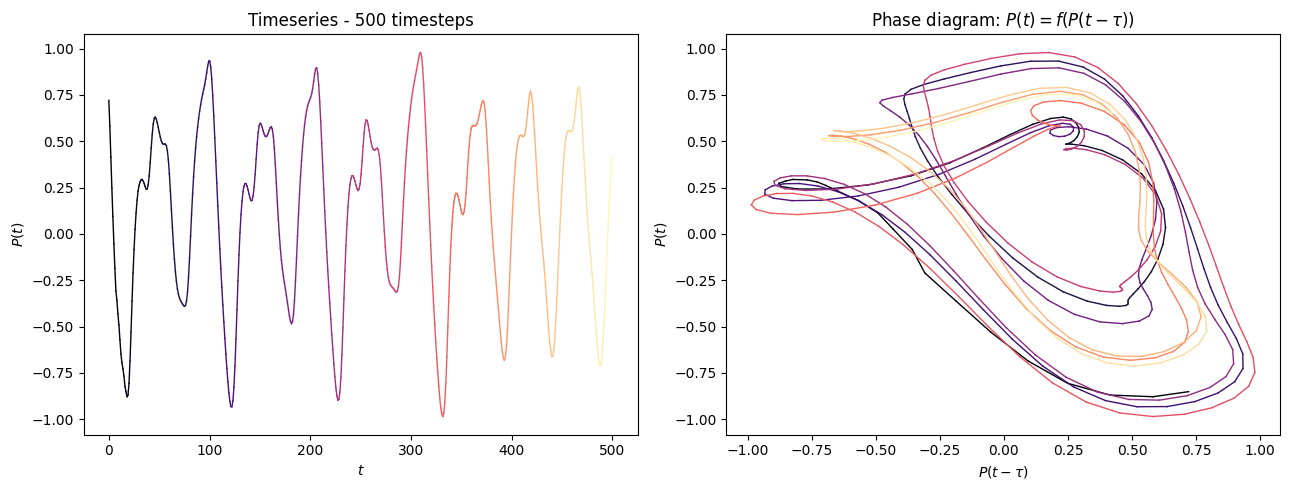

In [6]:
plot_mackey_glass(X, 500, tau)

In [7]:
def plot_train_test(X_train, y_train, X_test, y_test):
    sample = 500
    test_len = X_test.shape[0]
    fig = plt.figure(figsize=(15, 5))
    plt.plot(np.arange(0, 500), X_train[-sample:], label="Training data")
    plt.plot(np.arange(0, 500), y_train[-sample:], label="Training ground truth")
    plt.plot(np.arange(500, 500+test_len), X_test, label="Testing data")
    plt.plot(np.arange(500, 500+test_len), y_test, label="Testing ground truth")
    plt.legend()
    plt.show()

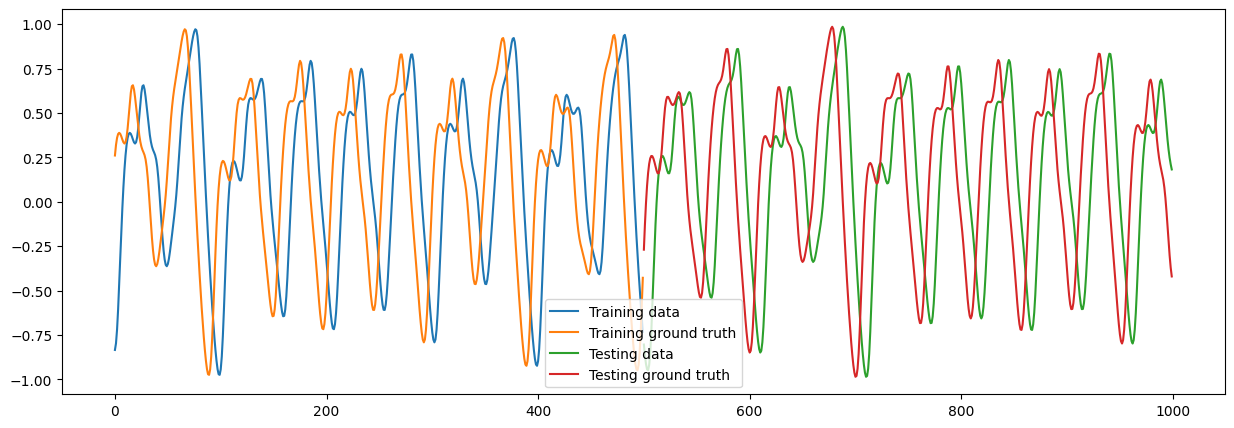

In [8]:
from lib_lorenz.datasets import to_forecasting

x, y = to_forecasting(X, forecast=10)
X_train1, y_train1 = x[:2000], y[:2000]
X_test1, y_test1 = x[2000:], y[2000:]

plot_train_test(X_train1, y_train1, X_test1, y_test1)

In [9]:
units = 100
leak_rate = 0.3
spectral_radius = 1.25
input_scaling = 1.0
connectivity = 0.1
input_connectivity = 0.2
regularization = 1e-8
seed = 1234

In [11]:
from reservoirpy.nodes import Reservoir, Ridge

reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                      lr=leak_rate, rc_connectivity=connectivity,
                      input_connectivity=input_connectivity, seed=seed)

readout   = Ridge(1, ridge=regularization)

esn = reservoir >> readout

In [12]:
y = esn(X[0])  # initialisation
reservoir.Win is not None, reservoir.W is not None, readout.Wout is not None

(True, True, True)

In [13]:
np.all(readout.Wout == 0.0)

True

In [14]:
esn = esn.fit(X_train1, y_train1)

Running Model-0:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-0: 377it [00:00, 3768.19it/s]           
Running Model-0: 758it [00:00, 3791.11it/s]
Running Model-0: 1138it [00:00, 3628.52it/s]
Running Model-0: 1502it [00:00, 3400.79it/s]
Running Model-0: 2000it [00:00, 3490.49it/s]
Running Model-0: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]


Fitting node Ridge-0...


In [15]:
def plot_readout(readout):
    Wout = readout.Wout
    bias = readout.bias
    Wout = np.r_[bias, Wout]

    fig = plt.figure(figsize=(15, 5))

    ax = fig.add_subplot(111)
    ax.grid(axis="y")
    ax.set_ylabel("Coefs. of $W_{out}$")
    ax.set_xlabel("reservoir neurons index")
    ax.bar(np.arange(Wout.size), Wout.ravel()[::-1])

    plt.show()

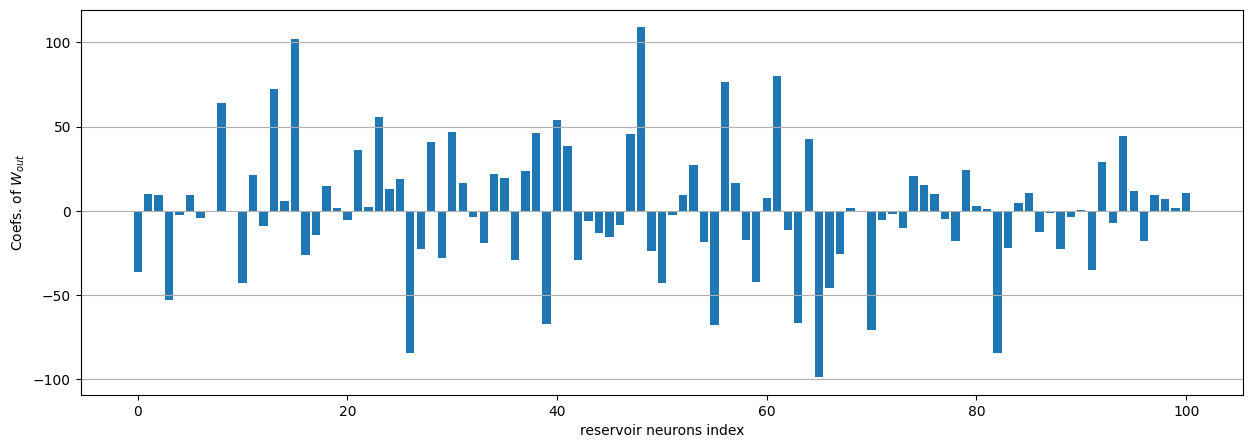

In [16]:
plot_readout(readout)

In [17]:
def plot_results(y_pred, y_test, sample=500):

    fig = plt.figure(figsize=(15, 7))
    plt.subplot(211)
    plt.plot(np.arange(sample), y_pred[:sample], lw=3, label="ESN prediction")
    plt.plot(np.arange(sample), y_test[:sample], linestyle="--", lw=2, label="True value")
    plt.plot(np.abs(y_test[:sample] - y_pred[:sample]), label="Absolute deviation")

    plt.legend()
    plt.show()

In [18]:

y_pred1 = esn.run(X_test1)

Running Model-0: 500it [00:00, 4605.51it/s]           


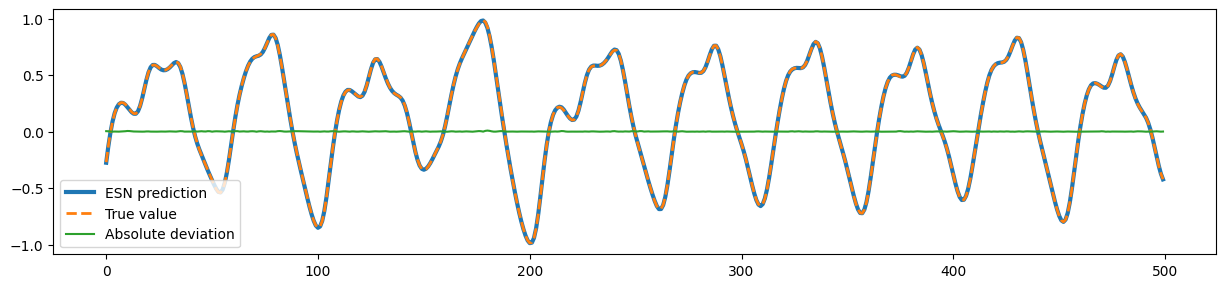

In [19]:

plot_results(y_pred1, y_test1)

In [20]:
rsquare(y_test1, y_pred1), nrmse(y_test1, y_pred1)

(0.999977070272825, 0.0011430604632023263)

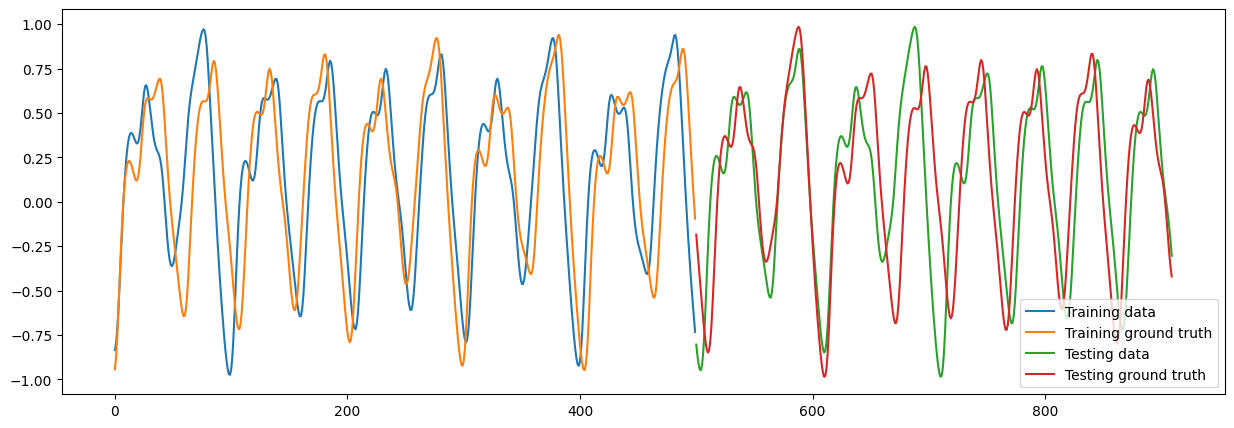

In [23]:
x, y = to_forecasting(X, forecast=100)
X_train2, y_train2 = x[:2000], y[:2000]
X_test2, y_test2 = x[2000:], y[2000:]

plot_train_test(X_train2, y_train2, X_test2, y_test2)

In [24]:
y_pred2 = esn.fit(X_train2, y_train2).run(X_test2)

Running Model-0:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-0: 441it [00:00, 4406.02it/s]           
Running Model-0: 882it [00:00, 4180.46it/s]
Running Model-0: 1301it [00:00, 4070.15it/s]
Running Model-0: 2000it [00:00, 3798.21it/s]
Running Model-0: 100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


Fitting node Ridge-0...


Running Model-0: 410it [00:00, 3621.78it/s]           


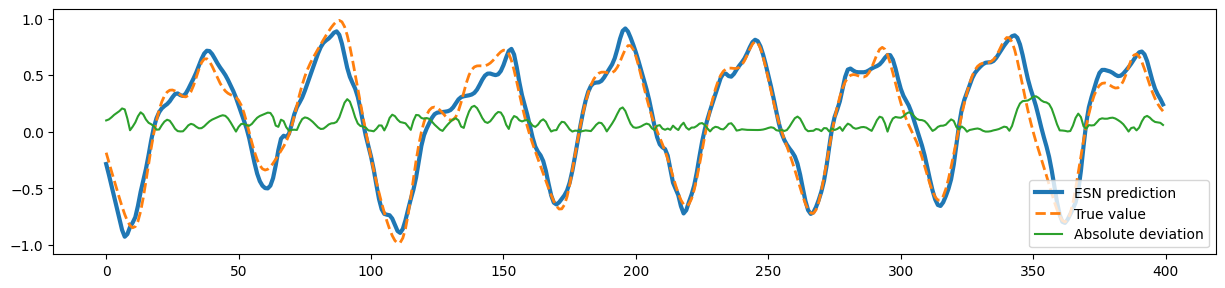

In [25]:
plot_results(y_pred2, y_test2, sample=400)

In [ ]:
units = 500
leak_rate = 0.3
spectral_radius = 0.99
input_scaling = 1.0
connectivity = 0.1      # - density of reservoir internal matrix
input_connectivity = 0.2  # and of reservoir input matrix
regularization = 1e-4
seed = 1234             # for reproducibility

In [26]:
def plot_generation(X_gen, X_t, nb_generations, warming_out=None, warming_inputs=None, seed_timesteps=0):

    plt.figure(figsize=(15, 5))
    if warming_out is not None:
        plt.plot(np.vstack([warming_out, X_gen]), label="Generated timeseries")
    else:
        plt.plot(X_gen, label="Generated timeseries")

    plt.plot(np.arange(nb_generations)+seed_timesteps, X_t, linestyle="--", label="Real timeseries")

    if warming_inputs is not None:
        plt.plot(np.arange(seed_timesteps), warming_inputs, linestyle="--", label="Warmup")

    plt.plot(np.arange(nb_generations)+seed_timesteps, np.abs(X_t - X_gen),
             label="Absolute deviation")

    if seed_timesteps > 0:
        plt.fill_between([0, seed_timesteps], *plt.ylim(), facecolor='lightgray', alpha=0.5, label="Warmup")

    plt.plot([], [], ' ', label=f"$R^2 = {round(rsquare(X_t, X_gen), 4)}$")
    plt.plot([], [], ' ', label=f"$NRMSE = {round(nrmse(X_t, X_gen), 4)}$")
    plt.legend()
    plt.show()

In [27]:
esn = reset_esn()

x, y = to_forecasting(X, forecast=1)
X_train3, y_train3 = x[:2000], y[:2000]
X_test3, y_test3 = x[2000:], y[2000:]

esn = esn.fit(X_train3, y_train3)

Running Model-1:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1: 437it [00:00, 4364.85it/s]           
Running Model-1: 874it [00:00, 3871.98it/s]
Running Model-1: 1265it [00:00, 3374.76it/s]
Running Model-1: 1609it [00:00, 3115.69it/s]
Running Model-1: 2000it [00:00, 3304.28it/s]
Running Model-1: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


Fitting node Ridge-1...


In [28]:
seed_timesteps = 100

warming_inputs = X_test3[:seed_timesteps]

warming_out = esn.run(warming_inputs, reset=True)  # warmup

Running Model-1: 100it [00:00, 5786.36it/s]           


In [29]:
nb_generations = 400

X_gen = np.zeros((nb_generations, 1))
y = warming_out[-1]
for t in range(nb_generations):  # generation
    y = esn(y)
    X_gen[t, :] = y

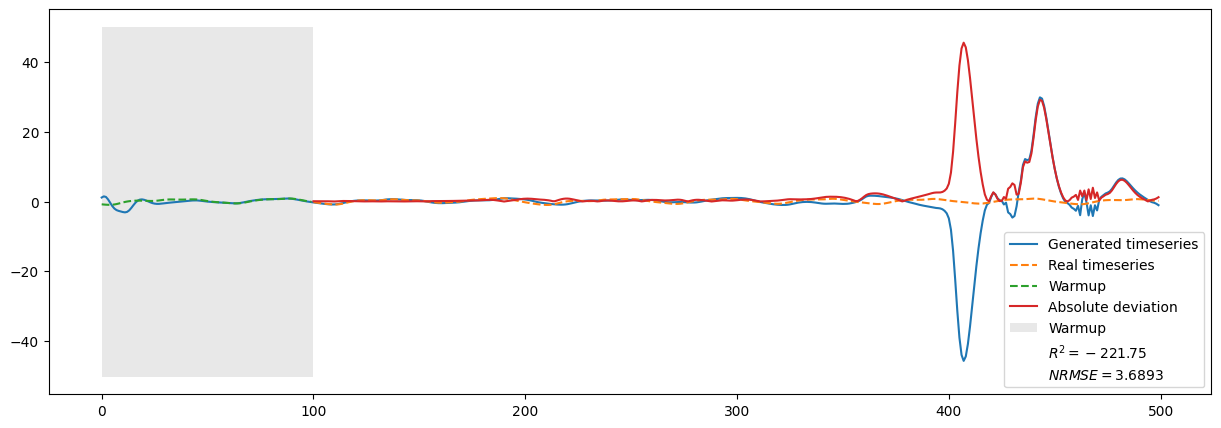

In [30]:
X_t = X_test3[seed_timesteps: nb_generations+seed_timesteps]
plot_generation(X_gen, X_t, nb_generations, warming_out=warming_out,
                warming_inputs=warming_inputs, seed_timesteps=seed_timesteps)